# Virtual Twins (VT) Method for Estimating Individual Treatment Effects (ITE)

The Virtual Twins (VT) method is a machine learning approach to estimating Individual Treatment Effects (ITE) in randomized controlled trials (RCTs). This method involves multiple steps, including data preparation, training predictive models, computing ITE, and identifying subgroups that benefit from treatment.

---

## Step 1: Data Preparation
Before implementing the VT method, we must ensure that the dataset is clean and formatted correctly. The dataset contains a binary outcome (*survival*), a treatment variable (*THERAPY*), and several covariates.

### Mathematical Formulation:
Let:

- \( Y \) be the outcome variable (survival).
- \( T \) be the treatment assignment (*THERAPY*), where \( T = 1 \) represents treatment and \( T = 0 \) represents control.
- \( X \) be the set of covariates describing patient characteristics.

### Implementation:
- Load the dataset from a `.csv` file.
- Define the outcome (*survival*) and treatment (*THERAPY*) variables.
- Preprocess the data by handling missing values and encoding categorical variables if necessary.

---

In [1]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from Functions.vt_data import VTObject
from Functions.vt_data import VTForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

# Step 1: Load dataset
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))


✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

### Preprocessing and subsets

In [3]:
#Define Outcome and Treatment Fields
outcome_field = "survival"     # Binary outcome (1 = survived, 0 = died)
treatment_field = "THERAPY"    # 1 = active treatment, 0 = control

#Initialize VTObject with interactions enabled
vt_object = VTObject(sepsis_data, outcome_field, treatment_field, interactions=False)

#Prepare Features (X_simple) and Outcome (y)
y = vt_object.get_Y()
treatment = vt_object.get_treatment()

#Simple Random Forest
featuresWithY = [col for col in sepsis_data.columns if col != outcome_field]
X_simple = sepsis_data[featuresWithY]

#Double Random Forest
X_double = vt_object.get_X()


#K-Fold Cross Validation
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X_kfold = vt_object.get_X().values
y_kfold = vt_object.get_Y().values
treatment_kfold = sepsis_data[treatment_field].values



# Training the Models

### Simple Random Forest Approach
The **Simple Random Forest Approach** trains a single **Random Forest model** on the **entire dataset**, including both treated and control patients. This model directly predicts the **individual treatment effect (ITE)**.

#### Mathematical Formulation:
Instead of training separate models for treated and control groups, we train a single model:

$$
P(Y = 1 \mid T, X)
$$

This model learns the probability of survival given both the treatment and covariates.

#### Implementation:
1. Train a **single Random Forest model** using the entire dataset, including the treatment variable.
2. Use the model to predict survival probabilities for both scenarios:
   - **With treatment** $( T = 1 )$.
   - **Without treatment** $( T = 0 )$.
3. Compute **ITE** by taking the difference between the predicted probabilities.

This approach is computationally simpler but may introduce bias compared to the **Double Random Forest Approach**.

---

In [4]:
#Train a Single Random Forest Model
print("🚀 Training Single Random Forest Model...")

rf_unified = RandomForestClassifier(n_estimators=200, random_state=123)
rf_unified.fit(X_simple, y)

print("✅ Single Random Forest Training Complete")
    
#Predict Outcomes Under Treatment and Control
X_treated = X_simple.copy()
X_treated[treatment_field] = 1  # Set treatment to 1 for all

X_control = X_simple.copy()
X_control[treatment_field] = 0  # Set treatment to 0 for all

# Predict probabilities
P1_hat_simple = rf_unified.predict_proba(X_treated)[:, 1]  # P(Y=1 | T=1, X)
P0_hat_simple = rf_unified.predict_proba(X_control)[:, 1]  # P(Y=1 | T=0, X)

🚀 Training Single Random Forest Model...
✅ Single Random Forest Training Complete


### Double Random Forest Approach (More Robust)
To improve accuracy, we implement the **Double Random Forest Approach**, which trains two separate models:

$$
\hat{P}_1(X) = P(Y = 1 \mid T = 1, X)
$$

$$
\hat{P}_0(X) = P(Y = 1 \mid T = 0, X)
$$

where:

- $( \hat{P}_1(X) )$ is the predicted probability of survival under treatment.
- $( \hat{P}_0(X) )$ is the predicted probability of survival under control.

#### Implementation:
1. Train **one Random Forest model** using only the **treated group** $( T = 1 )$.
2. Train **another Random Forest model** using only the **control group** $( T = 0 )$.
3. Compute **ITE** for each patient:

   $$
   ITE_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
   $$

In [5]:
#Subset into treated and control groups
X_treated = X_double[treatment == 1]
y_treated = y[treatment == 1]
X_control = X_double[treatment == 0]
y_control = y[treatment == 0]

#Train Random Forest Models
print("🚀 Training Double Random Forest Models using Virtual Twin...")

model_rf_trt1 = RandomForestClassifier(n_estimators=200, random_state=123)
model_rf_trt0 = RandomForestClassifier(n_estimators=200, random_state=123)

model_rf_trt1.fit(X_treated, y_treated)
model_rf_trt0.fit(X_control, y_control)

print("✅ Double Random Forest Training Complete")

#Apply Virtual Twin double forest
vt_double_forest = VTForest(
    forest_type="double",
    vt_data=vt_object,
    model_trt1=model_rf_trt1,
    model_trt0=model_rf_trt0
)

#Compute ITE and probabilities
P1_hat_double = vt_double_forest.P1_hat
P0_hat_double = vt_double_forest.P0_hat


🚀 Training Double Random Forest Models using Virtual Twin...
✅ Double Random Forest Training Complete



#### **Comparison of Approaches**
| Approach                  | Description | Strengths | Weaknesses |
|---------------------------|-------------|------------|------------|
| **Simple Random Forest** | Single RF model trained on entire dataset | Computationally efficient | May introduce bias |
| **Double Random Forest** | Separate RF models for treated and control groups | More accurate | Requires more computational power |

### K-Fold Cross-Validation for Robustness
Instead of training models on the full dataset, we use **K-Fold Cross-Validation** to prevent overfitting. This ensures that the model does not use the same data for training and prediction.

### Implementation:
- Split the dataset into $( k )$ folds.
- Train the model on $( k-1 )$ folds and test it on the remaining fold.
- Repeat $( k )$ times and average the results.

---

In [6]:
# Initialize K-Fold parameters
k_folds = 5  # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Initialize storage for predictions
P1_hat_kfold = np.zeros(len(X_kfold))  # Probability of survival for treated (P1i^)
P0_hat_kfold = np.zeros(len(X_kfold))  # Probability of survival for control (P0i^)

print(f"🚀 Running {k_folds}-Fold Cross-Validation...")

# Perform K-Fold Training
for train_index, test_index in kf.split(X_kfold):
    
    # Create train-test splits
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y[train_index], y[test_index]
    treatment_train, treatment_test = treatment_kfold[train_index], treatment_kfold[test_index]

    # Train separate models for treated and control groups
    X_train_treated = X_train[treatment_train == 1]
    y_train_treated = y_train[treatment_train == 1]

    X_train_control = X_train[treatment_train == 0]
    y_train_control = y_train[treatment_train == 0]

    rf_treated = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_treated.fit(X_train_treated, y_train_treated)

    rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_control.fit(X_train_control, y_train_control)

    # Predict probabilities for test set
    P1_hat_kfold[test_index] = rf_treated.predict_proba(X_test)[:, 1]
    P0_hat_kfold[test_index] = rf_control.predict_proba(X_test)[:, 1]

print("✅ K-Fold Cross-Validation Complete")

🚀 Running 5-Fold Cross-Validation...
✅ K-Fold Cross-Validation Complete


### Compute ITE Absolute method

In [7]:
ITE_simple = P1_hat_simple - P0_hat_simple
ITE_double = P1_hat_double - P0_hat_double
ITE_kfold = P1_hat_kfold - P0_hat_kfold

## Results

Simple Random Forest Result

In [8]:
# Calculate ITE and Classify
effect_labels = ["Beneficial" if ite > 0 else "Harmful" if ite < 0 else "No Effect" for ite in ITE_simple]

# Save Results
simplerandom = sepsis_data.copy()
simplerandom["P1_hat"] = P1_hat_simple
simplerandom["P0_hat"] = P0_hat_simple
simplerandom["ITE"] = ITE_simple
simplerandom["Effect_Label"] = effect_labels

output_path = os.path.join("dataset", "SimpleRandomForest.csv")
simplerandom.to_csv(output_path, index=False)

print("✅ ITE computation complete. Results saved to:", output_path)
print(simplerandom[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(20))

✅ ITE computation complete. Results saved to: dataset\SimpleRandomForest.csv
    P1_hat  P0_hat    ITE Effect_Label
0    0.165   0.180 -0.015      Harmful
1    0.925   0.705  0.220   Beneficial
2    0.100   0.185 -0.085      Harmful
3    0.050   0.130 -0.080      Harmful
4    0.120   0.180 -0.060      Harmful
5    0.135   0.145 -0.010      Harmful
6    0.650   0.795 -0.145      Harmful
7    0.060   0.180 -0.120      Harmful
8    0.060   0.120 -0.060      Harmful
9    0.760   0.695  0.065   Beneficial
10   0.240   0.185  0.055   Beneficial
11   0.795   0.710  0.085   Beneficial
12   0.170   0.245 -0.075      Harmful
13   0.885   0.630  0.255   Beneficial
14   0.425   0.160  0.265   Beneficial
15   0.255   0.175  0.080   Beneficial
16   0.205   0.185  0.020   Beneficial
17   0.040   0.070 -0.030      Harmful
18   0.105   0.175 -0.070      Harmful
19   0.190   0.210 -0.020      Harmful


Double Random Forest Result

In [9]:
# Save results
doublerandom = sepsis_data.copy()
doublerandom["P1_hat"] = P1_hat_double
doublerandom["P0_hat"] = P0_hat_double
doublerandom["ITE"] = ITE_double

# Add effect label
def label_effect(ite):
    if ite > 0:
        return "Beneficial"
    elif ite < 0:
        return "Harmful"
    else:
        return "No Effect"

doublerandom["Effect_Label"] = doublerandom["ITE"].apply(label_effect)

# Save results
output_path = os.path.join("dataset", "DoubleRandom.csv")
doublerandom.to_csv(output_path, index=False)

print(f"📁 Results saved to: {output_path}")
print(doublerandom[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(20))

📁 Results saved to: dataset\DoubleRandom.csv
    P1_hat  P0_hat    ITE Effect_Label
0    0.125   0.470 -0.345      Harmful
1    0.955   0.470  0.485   Beneficial
2    0.125   0.375 -0.250      Harmful
3    0.055   0.315 -0.260      Harmful
4    0.115   0.475 -0.360      Harmful
5    0.255   0.135  0.120   Beneficial
6    0.280   0.830 -0.550      Harmful
7    0.025   0.470 -0.445      Harmful
8    0.040   0.300 -0.260      Harmful
9    0.770   0.395  0.375   Beneficial
10   0.395   0.110  0.285   Beneficial
11   0.840   0.460  0.380   Beneficial
12   0.210   0.390 -0.180      Harmful
13   0.945   0.450  0.495   Beneficial
14   0.780   0.125  0.655   Beneficial
15   0.465   0.195  0.270   Beneficial
16   0.400   0.155  0.245   Beneficial
17   0.090   0.110 -0.020      Harmful
18   0.075   0.370 -0.295      Harmful
19   0.175   0.335 -0.160      Harmful


K Fold Result

In [10]:
# Store results in DataFrame
kfold = sepsis_data.copy()
kfold["P1_hat"] = P1_hat_kfold
kfold["P0_hat"] = P0_hat_kfold
kfold["ITE"] = ITE_kfold

print("✅ Computation of Individual Treatment Effects (ITE) Complete")
print(kfold[["P1_hat", "P0_hat", "ITE"]].head(20))

#  Save results
kfold.to_csv("dataset/Kfold.csv", index=False)

✅ Computation of Individual Treatment Effects (ITE) Complete
    P1_hat  P0_hat    ITE
0    0.260   0.625 -0.365
1    0.770   0.600  0.170
2    0.250   0.360 -0.110
3    0.145   0.290 -0.145
4    0.395   0.395  0.000
5    0.205   0.430 -0.225
6    0.350   0.450 -0.100
7    0.120   0.475 -0.355
8    0.175   0.345 -0.170
9    0.245   0.195  0.050
10   0.285   0.495 -0.210
11   0.650   0.340  0.310
12   0.560   0.250  0.310
13   0.820   0.450  0.370
14   0.780   0.300  0.480
15   0.500   0.375  0.125
16   0.335   0.385 -0.050
17   0.095   0.315 -0.220
18   0.265   0.430 -0.165
19   0.585   0.335  0.250


# Visualization and Results

### 1. Classification

The **classification tree** helps categorize patients based on whether the treatment is beneficial.

### Mathematical Formula:
A classification model is trained to predict whether a patient benefits from treatment based on their covariates:

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

where $( Z_i )$ is an indicator variable denoting whether the treatment is beneficial for patient $( i )$.

### Implementation:
- We choose the ITE with the models trained on **Double Random Forest** to avoid bias
- Train a classifier using the estimated $( ITE )$ values.
- Identify the subgroups for which the treatment is most effective.


Trained classification trees: ['tree_threshold_-0.02', 'tree_threshold_0.16', 'tree_threshold_0.33', 'tree_threshold_0.47']


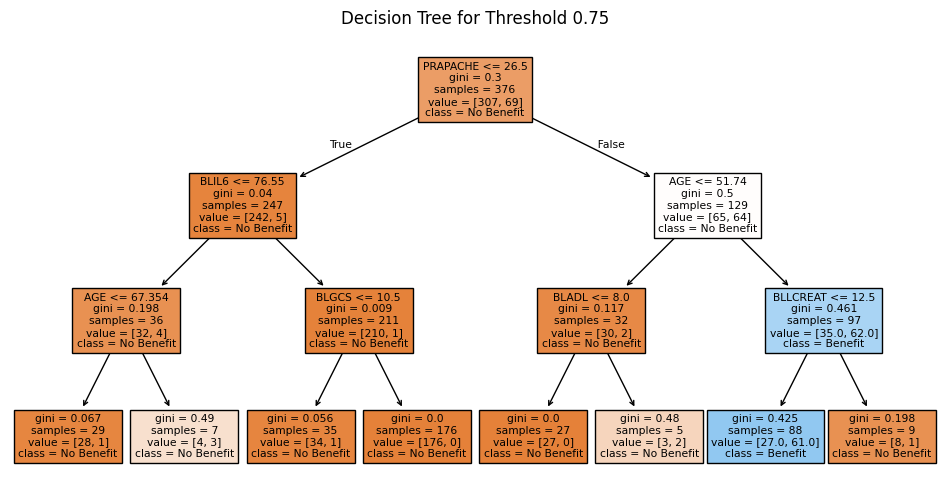


Decision Tree Rules:
|--- PRAPACHE <= 26.50
|   |--- BLIL6 <= 76.55
|   |   |--- AGE <= 67.35
|   |   |   |--- class: 0
|   |   |--- AGE >  67.35
|   |   |   |--- class: 0
|   |--- BLIL6 >  76.55
|   |   |--- BLGCS <= 10.50
|   |   |   |--- class: 0
|   |   |--- BLGCS >  10.50
|   |   |   |--- class: 0
|--- PRAPACHE >  26.50
|   |--- AGE <= 51.74
|   |   |--- BLADL <= 8.00
|   |   |   |--- class: 0
|   |   |--- BLADL >  8.00
|   |   |   |--- class: 0
|   |--- AGE >  51.74
|   |   |--- BLLCREAT <= 12.50
|   |   |   |--- class: 1
|   |   |--- BLLCREAT >  12.50
|   |   |   |--- class: 0


Subgroup Statistics:
   Subgroup  Treatment_size  Control_size  Treatment_event_rate  \
0         3              23            14              0.250676   
1         4               7             2              0.484444   
2         6              31            17              0.311458   
3         7             151            68              0.237374   
4        10              24             8         

In [11]:
# Define Z* (Binary Classification)
# User-defined threshold (c) using quantiles of the ITE distribution
thresholds = np.quantile(ITE_double, q=np.arange(0.5, 0.9, 0.1))  # 50th to 80th percentiles

# Create a dictionary to store classification trees for different thresholds
classification_trees = {}

# Loop through each threshold to train a classification tree for each
for c in thresholds:
    # Z_star: Binary classification based on ITE threshold
    Z_star = (ITE_double > c).astype(int)  # 1 if ITE > c, else 0

    # Split the data into training and testing sets
    X_train, X_test, Z_train, Z_test = train_test_split(X_double, Z_star, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, Z_train)

    # Store the trained model with a descriptive name based on the threshold
    classification_trees[f"tree_threshold_{c:.2f}"] = clf

# Display the trained classification trees
print(f"Trained classification trees: {list(classification_trees.keys())}")

# Choose the model with the closest threshold (e.g., closest to 0.75)
# You can customize this logic to choose based on other criteria as needed.
closest_threshold = 0.75  # For example, we can pick 0.75 if it exists, or the closest one
closest_key = min(classification_trees.keys(), key=lambda k: abs(float(k.split('_')[-1]) - closest_threshold))

# Feature names for the decision tree plot
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_double.shape[1])]

# Plot the tree for the selected model
plt.figure(figsize=(12, 6))
plot_tree(classification_trees[closest_key], feature_names=feature_names, class_names=["No Benefit", "Benefit"], filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()

# Train decision tree for subgroup identification
tree = classification_trees[closest_key]

# Print decision rules
print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=features))

# Assign subgroup IDs using the tree
doublerandom = pd.read_csv("dataset/DoubleRandom.csv")
doublerandom["Subgroup"] = tree.apply(X_double)

# Calculate subgroup statistics
subgroup_stats = doublerandom.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Compute Risk Ratio (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Display results
print("\nSubgroup Statistics:")
print(subgroup_stats)

## 2. Regression Tree

The regression tree predicts the exact value of $Z_i$ instead of classifying it.

### Mathematical Formula:

Instead of classifying patients, we directly model $Z_i$ using patient covariates $X$:

$$
Z_i = f(X) + \epsilon
$$

where:

- $f(X)$ is the function learned by the regression tree.
- $\epsilon$ is random noise.

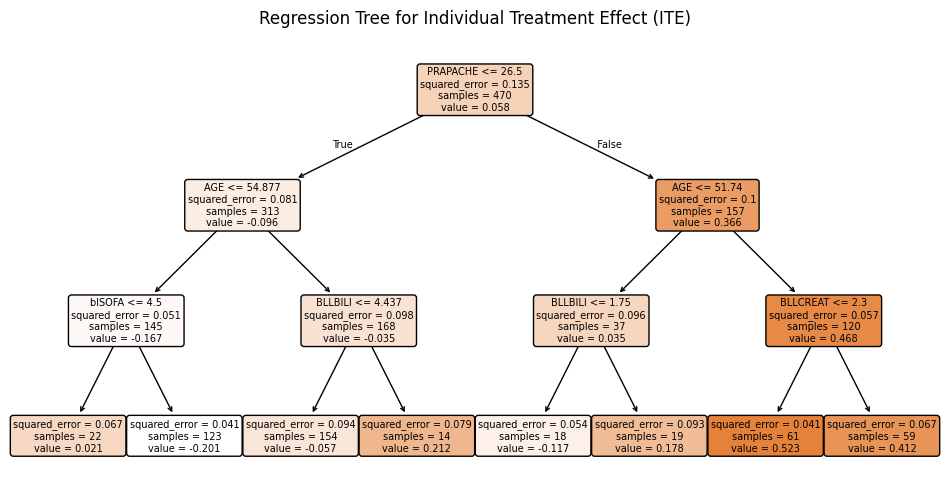


Decision Tree Rules:
|--- PRAPACHE <= 26.50
|   |--- AGE <= 54.88
|   |   |--- blSOFA <= 4.50
|   |   |   |--- value: [0.02]
|   |   |--- blSOFA >  4.50
|   |   |   |--- value: [-0.20]
|   |--- AGE >  54.88
|   |   |--- BLLBILI <= 4.44
|   |   |   |--- value: [-0.06]
|   |   |--- BLLBILI >  4.44
|   |   |   |--- value: [0.21]
|--- PRAPACHE >  26.50
|   |--- AGE <= 51.74
|   |   |--- BLLBILI <= 1.75
|   |   |   |--- value: [-0.12]
|   |   |--- BLLBILI >  1.75
|   |   |   |--- value: [0.18]
|   |--- AGE >  51.74
|   |   |--- BLLCREAT <= 2.30
|   |   |   |--- value: [0.52]
|   |   |--- BLLCREAT >  2.30
|   |   |   |--- value: [0.41]


Subgroup Statistics:
   Subgroup  Treatment_size  Control_size  Treatment_event_rate  \
0         3              13             9              0.319318   
1         4              82            41              0.121789   
2         6             110            44              0.340195   
3         7               7             7              0.441071   
4  

In [12]:
regression_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
regression_tree.fit(X_double, ITE_double)

# Step 3: Visualize the trained regression tree
plt.figure(figsize=(12, 6))
plot_tree(
    regression_tree,
    feature_names=X_double.columns,
    filled=True,
    rounded=True,
    precision=3
)
plt.title("Regression Tree for Individual Treatment Effect (ITE)")
plt.show()

# Train decision tree for subgroup identification
tree = regression_tree

# Print decision rules
print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=features))

# Assign subgroup IDs using the tree
doublerandom = pd.read_csv("dataset/DoubleRandom.csv")
doublerandom["Subgroup"] = tree.apply(X_double)

# Calculate subgroup statistics
subgroup_stats = doublerandom.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Compute Risk Ratio (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Display results
print("\nSubgroup Statistics:")
print(subgroup_stats)

# SHAP Implementation

### Regression Explaination

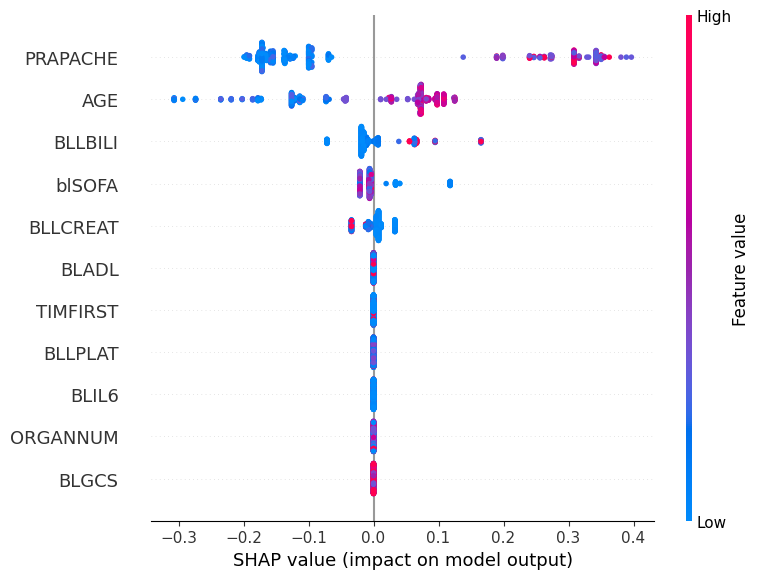

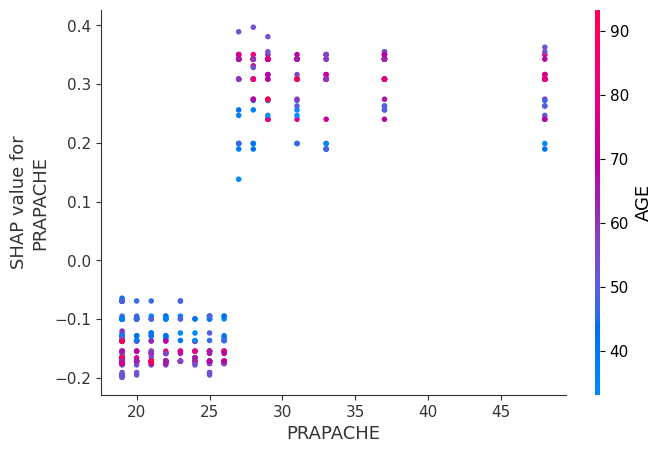

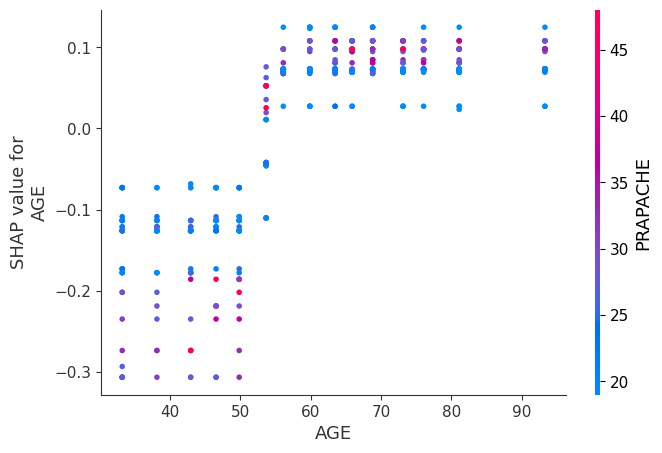

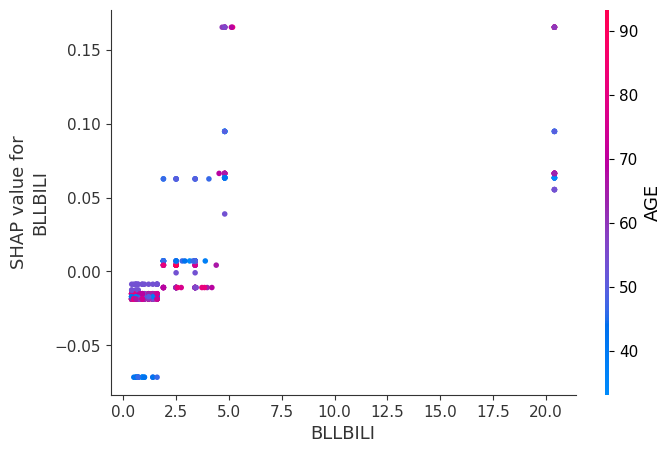

In [13]:
# Use SHAP TreeExplainer
explainer = shap.TreeExplainer(regression_tree)
shap_values = explainer.shap_values(X_double)

# Create folder to store plots
# os.makedirs("shap_plots", exist_ok=True)

# Summary plot for regression
shap.summary_plot(shap_values, X_double, show=True) 
# fig = plt.gcf()  # Get current figure object
# fig.savefig("shap_plots/summary_plot.png", dpi=300, bbox_inches="tight")
# plt.close(fig)  # Close specific figure

# Get feature importance order (top features)
top_features = X_double.columns[np.argsort(np.abs(shap_values).mean(axis=0))[::-1]]

# Dependence plots for top 3 features
for i, feature in enumerate(top_features[:3], start=1):
    shap.dependence_plot(feature, shap_values, X_double, show=True) 
    # plt.savefig(f"shap_plots/dependence_plot_{i}_{feature}.png", dpi=300, bbox_inches="tight")
    # plt.close()

### Interpretation

### Classification Tree Explaination

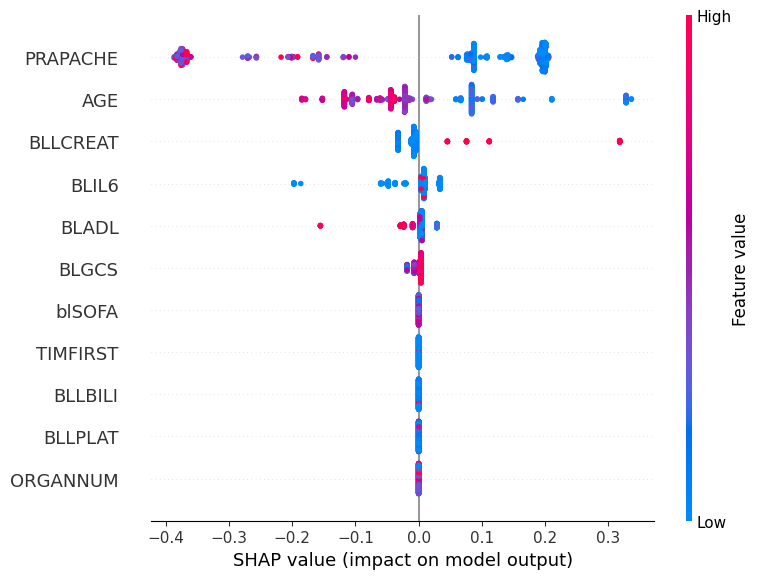

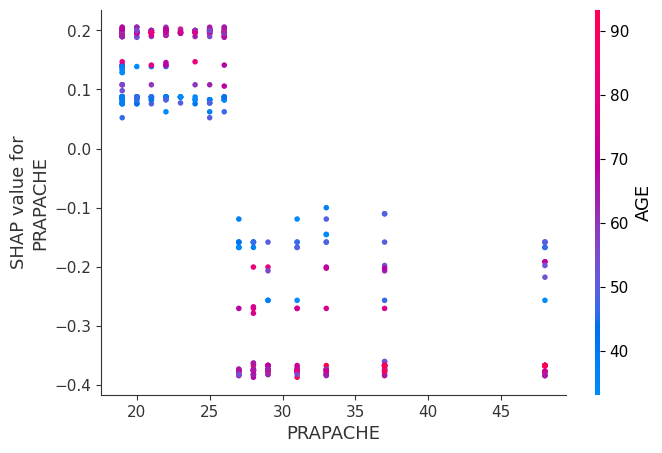

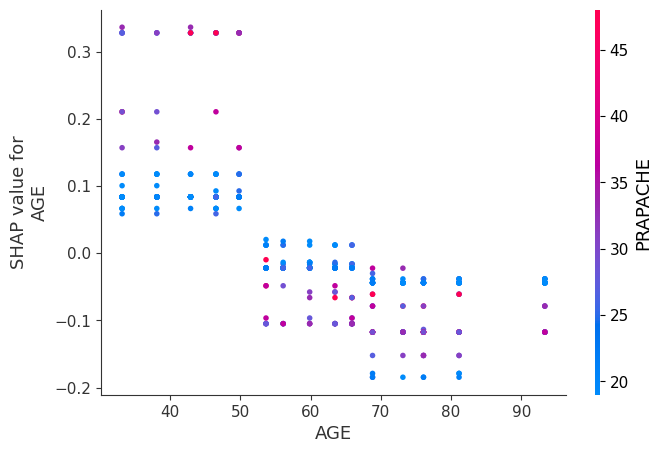

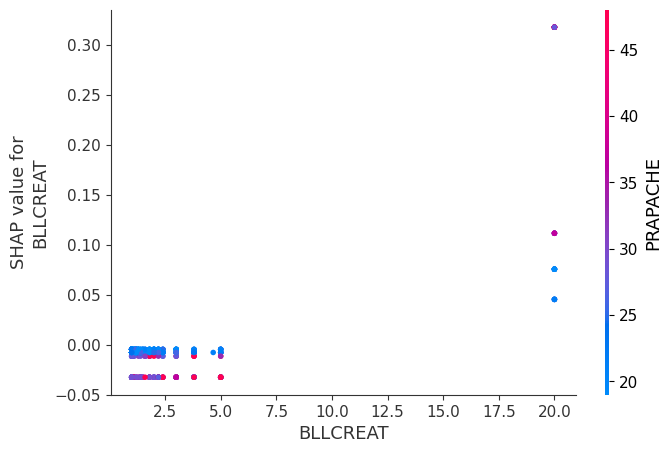

In [14]:
# Assuming you already have your model and test set ready
explainer = shap.TreeExplainer(classification_trees[closest_key])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_double)

# If it's a multi-class problem, shap_values is a list, and you need to access one class
# For example, if you want the SHAP values for the first class (index 0):
shap_values_class_0 = shap_values[0]

# Create output directory
# os.makedirs("shap_plots/classification", exist_ok=True)

#Beeswarm plot
shap.summary_plot(shap_values_class_0, X_double, show=True)
# plt.savefig("shap_plots/classification/summary_plot.png", dpi=300, bbox_inches="tight")
# plt.close()

# Get top 3 features by mean absolute SHAP value
top_features = X_double.columns[np.argsort(np.abs(shap_values_class_0).mean(axis=0))[::-1]]

#Print dependence plots
for i, feature in enumerate(top_features[:3], start=1): 
    shap.dependence_plot(feature, shap_values_class_0, X_double, show=True)
    # plt.savefig(f"shap_plots/classification/dependence_plot_{i}_{feature}.png", dpi=300, bbox_inches="tight")
    # plt.close()


### Interpretation

## Comparision of Results

# **Validation**

In [30]:
#Validation of ITE
X_V_train, X_V_test, y_V_train, y_V_test, t_V_train, t_V_test = train_test_split(
    X_double, y, treatment, test_size=0.3, random_state=42, stratify=treatment
)

# For control group
model_control = RandomForestRegressor(n_estimators=200, random_state=123)

# For treatment group
model_treatment = RandomForestRegressor(n_estimators=200, random_state=123)

#train models on training set
X_train_control = X_V_train[t_V_train == 0]
y_train_control = y_V_train[t_V_train == 0]

X_train_treatment = X_V_train[t_V_train == 1]
y_train_treatment = y_V_train[t_V_train == 1]

model_control.fit(X_train_control, y_train_control)
model_treatment.fit(X_train_treatment, y_train_treatment)

#Predict on test set
y_pred_control = model_control.predict(X_V_test)
y_pred_treatment = model_treatment.predict(X_V_test)

# Compute PITEs
PITE = y_pred_treatment - y_pred_control

Generate Pseudo-ITE for validation

For every treated person in test set we find control person with similar predictions

Pseudo ITE = actual Y(treated) - actual Y(matched control)

In [31]:
# Make sure t_V_test has only 94 elements
t_V_test = t_V_test[:len(y_test)]

# Reset indices for clean matching
y_test = y_test.reset_index(drop=True)
t_V_test = pd.Series(t_V_test).reset_index(drop=True)

# Identify indices of treated and control individuals
treated_idx = np.where(t_V_test == 1)[0]
control_idx = np.where(t_V_test == 0)[0]

# Build Pi(1) Pi(0) feature space for matching
treated_features = np.stack([y_pred_control[treated_idx], y_pred_treatment[treated_idx]], axis=1)
control_features = np.stack([y_pred_control[control_idx], y_pred_treatment[control_idx]], axis=1)

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

# Now create pseudo-ITE
matched_control_idx = control_idx[matched_idx.flatten()]
pseudo_ITE = y_test.iloc[treated_idx].values - y_test.iloc[matched_control_idx].values
# print(len(y_test), len(t_V_test))


Validate

In [32]:
# Regression: pseudo-ITE ~ PITE
X_reg = sm.add_constant(PITE[treated_idx])  # Add intercept
model = sm.OLS(pseudo_ITE, X_reg)
results = model.fit()

print(results.summary())

# Check if 95% CI of beta1 includes 1
ci = results.conf_int(alpha=0.05)
print(ci)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6747
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.415
Time:                        02:37:36   Log-Likelihood:                -65.952
No. Observations:                  64   AIC:                             135.9
Df Residuals:                      62   BIC:                             140.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0696      0.087      0.804      0.4